In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import training
import models
import metrics
from models import SpatioTemporalAutoencoder, TRACE_LSTM
from parameters import STAEParameters, TrainingParameters
from datautils import get_morning_data, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_TRACE_LSTM, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os
seed=42
torch_geometric.seed_everything(seed)


def sequence_stae(data, timesteps, hide_anomalies=False):
    sequence = []
    relational_edges, relations = generate_relational_edges(milemarkers=list(range(49)), timesteps=timesteps)
    static_edges = generate_edges(milemarkers=list(range(49)))
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(Data(x=torch.tensor(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy(), dtype=torch.float32), edge_index=static_edges)) # assumes time indices come sequentially, with full data it may not

        curr_graph = data_t[0]
        sequence.append([data_t[::-1], curr_graph])

    return sequence, kept_indices

hide_anomalies = False
optimal_params = load_best_parameters('TRACE_LSTM',hide_anomalies=hide_anomalies)
print(optimal_params)
training_params = TrainingParameters(
    learning_rate=optimal_params['learning_rate'],
    batch_size=1,
    timesteps=optimal_params['timesteps'],
    n_epochs=optimal_params['epochs'],
)

/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'dropout_rate': 0.1258292407047112, 'epochs': 4, 'flow_layers': 1, 'hidden_dim': 32, 'learning_rate': 2.924732238530936e-06, 'n_hidden_flow': 1, 'num_gcn_layers': 2, 'num_transformer_layers': 2, 'output_dim': 128, 'timesteps': 3}


In [2]:
data, test_data, _ = get_full_data()
data = normalize_data(data)
data = label_anomalies(data)
length = len(data.day.unique())
train_length = int(length * 0.8)
val_length = length - train_length
train_days = data.day.unique()[:train_length]
val_days = data.day.unique()[train_length:]

# Use .isin() to filter the DataFrame based on the days
train_data = data[data.day.isin(train_days)]
val_data = data[data.day.isin(val_days)]
train_sequence, kept_train_indices = sequence_stae(train_data, training_params.timesteps, hide_anomalies=hide_anomalies)
val_sequence, kept_val_indices = sequence_stae(val_data, training_params.timesteps, hide_anomalies=hide_anomalies)


100%|██████████| 2877/2877 [00:06<00:00, 436.04it/s]


In [3]:


num_features = 3
num_nodes = 196

model_params = {
    'input_features': num_features,
    'num_sensors': num_nodes,
    'hidden_dim': optimal_params['hidden_dim'],
    'num_transformer_layers': optimal_params['num_transformer_layers'],
    'output_dim': optimal_params['output_dim'],
    'num_gcn_layers': optimal_params['num_gcn_layers'],
    'flow_layers': optimal_params['flow_layers'],
    'n_hidden_flow':optimal_params['n_hidden_flow'],
    'dropout_rate':optimal_params['dropout_rate'],

    
}
using_pretrained = False

  0%|          | 0/4 [00:00<?, ?it/s]/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [03:27<10:21, 207.02s/it]

Epoch number 0 last 100 loss -545.9162335205078


 50%|█████     | 2/4 [06:55<06:56, 208.16s/it]

Epoch number 1 last 100 loss -653.2728094482422


 75%|███████▌  | 3/4 [10:26<03:29, 209.43s/it]

Epoch number 2 last 100 loss -709.3453857421875


100%|██████████| 4/4 [14:02<00:00, 210.67s/it]

Epoch number 3 last 100 loss -774.3556768798828


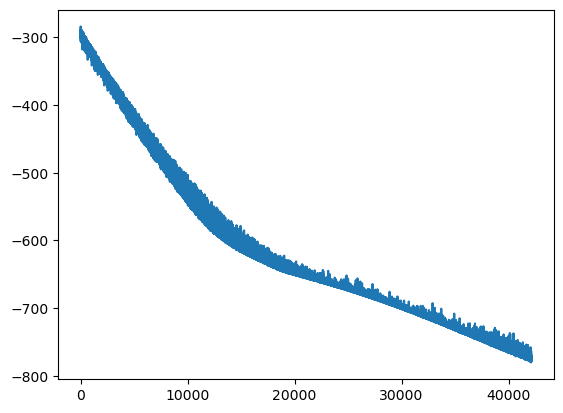

In [4]:


if not using_pretrained:
    model, losses= train_TRACE_LSTM(model_params, training_params, train_sequence,verbose=True)
    save_model(model, f'TRACE_LSTM_{hide_anomalies}_{seed}' )
    plt.plot(losses)

else:
    # model=TRACE_LSTM(**model_params)
    model = load_model(TRACE_LSTM,model_params,f'TRACE_LSTM_{hide_anomalies}_{seed}')
    

    

In [5]:

thresh = training.compute_threshold_f_gtnf(val_sequence,model , 'max')

In [6]:
_, df_test_data, _ = get_full_data()
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_stae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4797/4797 [00:13<00:00, 345.86it/s]


In [7]:
test_errors=training.test_f_gtnf(test_data, model, verbose=True)


100%|██████████| 4787/4787 [00:18<00:00, 262.62it/s]


In [8]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [9]:
path_results = 'saved_results/TRACE_LSTM/'
results = metrics.discrete_fp_delays_nll(thresh, test_errors, anomaly_labels, crash_reported)

# Check if the directory exists, and create it if it does not
if not os.path.exists(path_results):
    os.makedirs(path_results)

# Save the results to a CSV file
results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)

100%|██████████| 10000/10000 [05:02<00:00, 33.03it/s]

Found FPR of 0.011494252873563218 for 0.01
Found FPR of 0.024220032840722498 for 0.025
Found FPR of 0.05090311986863711 for 0.05
Found FPR of 0.10016420361247948 for 0.1
Found FPR of 0.19950738916256158 for 0.2
FPR 1% gives mean delay of 8.0 +/- 0.0 while missing 0.9166666666666666%.
FPR 2.5% gives mean delay of -4.5 +/- 9.495613022162743 while missing 0.75%.
FPR 5% gives mean delay of -0.5625 +/- 9.50801471128437 while missing 0.33333333333333337%.
FPR 10% gives mean delay of -8.444444444444445 +/- 5.31478255248951 while missing 0.25%.
FPR 20% gives mean delay of -11.666666666666666 +/- 4.089281382128432 while missing 0.25%.


In [10]:
calculate_auc(test_errors,anomaly_labels)

0.6240332765715908